In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')

from Q_find import Q_finder
from Q_find import charfun

###########################################################    
# Training
nclouds = 50000
npoints = 100

# The point clouds
means = torch.rand(nclouds)
covs = torch.rand(nclouds) * 0.2
normal = torch.randn(nclouds, npoints, 1)

# Ensure periodic b/c
for i in range(nclouds):
    normal[i, :, 0] = normal[i, :, 0]*covs[i] + means[i]
    normal[i, :, 0] %= 1

uniform = torch.rand(nclouds, npoints, 1)

trainset = torch.cat((normal, uniform))

# Function to calculate Q
R=0.1

# Time how long it takes to find the order parameter manually (start)
tic = time.perf_counter()

labels = Q_finder(trainset, R, npoints)

# # Time how long it takes to find the order parameter manually (end)
toc = time.perf_counter()

# Labels
labels = torch.tensor(labels).view(-1,1)

# Dataset
dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

print(f"To calculate the order parameters for training manually took {toc - tic:0.4f} seconds")

#########################################################
# Testing clouds

ncloudstest = 100#1000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1)

means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest) * 0.2

# Periodic b/c
for i in range(ncloudstest):
    normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1


testset = torch.cat((normaltest, uniformtest))

# Time how long it takes to find the order parameter manually (start)
tic = time.perf_counter()

# Find the order parameter
labels_test = Q_finder(testset, R, npoints)

# # Time how long it takes to find the order parameter manually (end)
toc = time.perf_counter()

# Labels
testlabels = torch.tensor(labels_test).view(-1,1)
test=testset

# Dataset
testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

print(f"To calculate the order parameters for testing manually took {toc - tic:0.4f} seconds")

To calculate the order parameters for training manually took 1525.6919 seconds
To calculate the order parameters for testing manually took 8.6255 seconds


In [2]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, train = True):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        
        
        # I'm not sure if it works better with or without RELU??
        if self.training:
            #x = F.relu(self.bn6(self.dropout(x) * 0.7))
            x = self.bn6(self.dropout(x) * 0.7)
        else:
            #x = F.relu(self.bn6(x))
            x = self.bn6(x)
        return x

In [3]:
############################################################
net = PointNetCls(k=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nepochs = 50

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.633
[1,   400] loss: 0.330
[1,   600] loss: 0.171
[2,   200] loss: 0.085
[2,   400] loss: 0.051
[2,   600] loss: 0.033
[3,   200] loss: 0.026
[3,   400] loss: 0.026
[3,   600] loss: 0.025
[4,   200] loss: 0.024
[4,   400] loss: 0.025
[4,   600] loss: 0.025
[5,   200] loss: 0.025
[5,   400] loss: 0.025
[5,   600] loss: 0.025
[6,   200] loss: 0.024
[6,   400] loss: 0.026
[6,   600] loss: 0.024
[7,   200] loss: 0.024
[7,   400] loss: 0.024
[7,   600] loss: 0.026
[8,   200] loss: 0.024
[8,   400] loss: 0.025
[8,   600] loss: 0.024
[9,   200] loss: 0.025
[9,   400] loss: 0.024
[9,   600] loss: 0.025
[10,   200] loss: 0.024
[10,   400] loss: 0.025
[10,   600] loss: 0.025
[11,   200] loss: 0.024
[11,   400] loss: 0.025
[11,   600] loss: 0.024
[12,   200] loss: 0.023
[12,   400] loss: 0.024
[12,   600] loss: 0.023
[13,   200] loss: 0.025
[13,   400] loss: 0.023
[13,   600] loss: 0.023
[14,   200] loss: 0.024
[14,   400] loss: 0.024
[14,   600] loss: 0.025
[15,   200] loss: 0

In [4]:
# Creates more test data - do not have to run again!!!

ncloudstest = 10000

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1)
R=0.1
means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest) * 0.2

# Periodic b/c
for i in range(ncloudstest):
    normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1


testset = torch.cat((normaltest, uniformtest))

# Timer start
tic = time.perf_counter()

labels_test = Q_finder(testset, R, npoints)

# Timer end
toc = time.perf_counter()

testlabels = torch.tensor(labels_test).view(-1,1)
# Labels
test=testset

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

print(f"To calculate the order parameters manually took {toc - tic:0.4f} seconds")

To calculate the order parameters manually took 864.2972 seconds


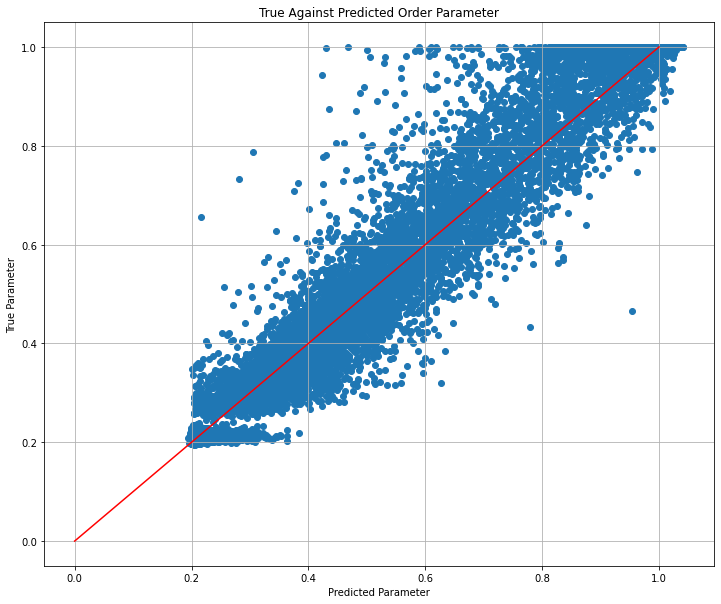

To calculate the order using PointNet took 0.4409 seconds for 10000 test clouds


In [5]:
#Set network to evaluate mode
net.eval()
#net.train()

# Timer start
tic = time.perf_counter()

outputs = net(test)

# Timer end
toc = time.perf_counter()

x = outputs.detach().numpy()
y = labels_test

# plot the data
plt.figure(figsize=(12,10))
plt.scatter(x,y)
plt.plot(np.linspace(0, 1, 10), np.power(np.linspace(0, 1, 10), 1), color = 'r', label = 'y = x')
plt.grid()
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.show()

print(f"To calculate the order using PointNet took {toc - tic:0.4f} seconds for {ncloudstest:1.0f} test clouds")

In [10]:
# For timing the network v manual for finding Q

cloud_timer = [10**i for i in range(5)]
timings_manual = []
repetitions = 3
timings_nn = []
for clouds in cloud_timer:
    print(clouds)
    # The point clouds
    normaltest = torch.randn(clouds, npointstest, 1)
    uniformtest = torch.rand(clouds, npointstest, 1)
    R=0.1
    means = torch.rand(ncloudstest)
    covs = torch.rand(ncloudstest) * 0.2

    # Periodic b/c
    for i in range(clouds):
        normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
        normaltest[i, :, 0] %= 1


    testset = torch.cat((normaltest, uniformtest))

    # Timer start
    tic = time.perf_counter()

    labels_test = Q_finder(testset, R, npoints)

    # Timer end
    toc = time.perf_counter()
    
    print(f"To calculate the order parameter manually took {toc-tic:0.4f} seconds for {clouds:1.0f} test clouds")
    
    timings_manual.append(toc-tic)

    cloudtime_nn = []
    with torch.no_grad():
        for rep in range(repetitions):
            tic = time.perf_counter()
            _ = net(test)
            toc = time.perf_counter()
            cloudtime_nn.append(toc - tic)

        mean_syn = np.sum(cloudtime_nn) / repetitions
        std_syn = np.std(cloudtime_nn)
        timings_nn.append([mean_syn, std_syn])

    print(f"To calculate the order parameter using PointNet took {mean_syn:0.4f} seconds for {clouds:1.0f} test clouds, averaged over {repetitions:1.0f} repetitions.")

1
To calculate the order parameter manually took 0.0783 seconds for 1 test clouds
To calculate the order parameter using PointNet took 0.3321 seconds for 1 test clouds, averaged over 3 repetitions.
10
To calculate the order parameter manually took 0.6711 seconds for 10 test clouds
To calculate the order parameter using PointNet took 0.3515 seconds for 10 test clouds, averaged over 3 repetitions.
100
To calculate the order parameter manually took 6.6542 seconds for 100 test clouds
To calculate the order parameter using PointNet took 0.3280 seconds for 100 test clouds, averaged over 3 repetitions.
1000
To calculate the order parameter manually took 74.1174 seconds for 1000 test clouds
To calculate the order parameter using PointNet took 0.6071 seconds for 1000 test clouds, averaged over 3 repetitions.
10000
To calculate the order parameter manually took 811.4452 seconds for 10000 test clouds
To calculate the order parameter using PointNet took 0.5502 seconds for 10000 test clouds, averag

IndexError: index 10000 is out of bounds for dimension 0 with size 10000

In [11]:
print(timings_manual, timings_nn)

[0.0782859860046301, 0.6710590989969205, 6.654168521999964, 74.1173830100015, 811.4451900010026] [[0.3320664353304892, 0.007951780654187918], [0.35148179366418236, 0.012032927671004875], [0.32795990299928235, 0.005433118412796829], [0.6070907983303186, 0.06691785786130881], [0.5502417973305759, 0.058614375941260934]]
